In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from sklearn.cluster import KMeans
import pandas as pd
from mpl_toolkits import mplot3d
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

In [3]:
def randCent(dataset, k):
    # n = number of variables
    n = dataset.shape[1]
    #Create empty array for centroids, k x n
    centroids = np.array(zeros((k, n)))
    #Centroids must be within the bounds of data, find min, max, range and then scale
    for j in range(n):
        minJ = min(dataset[:, j])
        maxJ = max(dataset[:, j])
        rangeJ = float(maxJ - minJ)
        centroids[:, j] = minJ + rangeJ*random.rand(k,1).T
    return centroids

In [4]:
def kMeans(dataset, k):
    # m = number of data points
    m = dataset.shape[0]
    #Cluster assesment will store the index & the error of the cluster
    clusterAssment = np.array(zeros((m, 2)))
    centroids = randCent(dataset, k)
    clusterChanged = True
    # While loop terminates of the clusters don't change
    while clusterChanged == True:
        clusterChanged = False
        # Calculate distance from each data point to the cluster and
        # assign the data point to the closest cluster
        for i in range(m):
            minDist = inf
            minIndex = -1
            for j in range(k):
                distJI = distEclud(centroids[j,:], dataset[i,:])
                if distJI < minDist:
                #If distance between points is less than the mindist
                #re-assign min distance and update the minindex
                    minDist = distJI
                    minIndex = j
                #If the index in the cluster assignment is not the same
                #as the minIndex then the cluster has changed
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist**2
        
        #Update the centroids to the mean of all the points in the cluster
        for cent in range(k):
            ptsInClust = dataset[nonzero(clusterAssment[:, 0] == cent)[0]]
            centroids[cent, :] = mean(ptsInClust, axis = 0)            

    return centroids, clusterAssment

In [5]:
def error(dataset, n, k):
    m = dataset.shape[1]
    set_printoptions(suppress=True)
    error = np.array(zeros((n, k + 1)))
    centroidsT = np.array(zeros((n, k, m)))
    tot_error = np.array(zeros((n, 2)))
    CAF = []
    # 
    for j in range(n):
        #Run the K-means algorithm n times
        centr, CA = kMeans(dataset, k)
        centroidsT[j] = centr
        CAF.append(CA)
        for i in range(k):
            #sum the error of each data point in a cluster
            error[j,i] = sum(CA[nonzero(CA[:,0] == i)])
        error[j, k] = j
        #Sum the total error of all clusters combined
        tot_error[j, 0] = sum(error[j, 0:k])
        tot_error[j, 1] = j
        
    CAF = np.array(CAF)
        
    p = 0
    #This removes any rogue values that arise
    while p < len(error):

        if np.all(error[p, 0:k]) == False:
            error = np.delete(error, p, axis = 0)
            tot_error = np.delete(tot_error, [p], axis = 0)
        p+=1

    
    return tot_error, centroidsT, CAF

In [6]:
def finalCent(total, centroid, CA):
    for i in range(total.shape[0]):
        if min(total[:, 0]) == total[i, 0]:
            ind = int(total[i, 1])
            t_error = total[i, 0]
    return centroid[ind], t_error, CA[ind]

In [7]:
def KmeansCentr(dataset, n, k):
    t, c, ca =  error(dataset, n, k)
    centiMan, terror, CAF = finalCent(t, c, ca)
    return centiMan, terror, CAF

In [8]:
def pcaScale(data, inf):
    scaler = StandardScaler()
    scaler.fit(data)
    sdata = scaler.transform(data)
    pca = PCA(inf)
    pca.fit(data)
    pcadata = pca.transform(data)

    return pcadata

In [9]:
#This plots all the data points with different markers depending on the cluster that it belongs to
def plot(data, ca, k):

    i_cluster = []
    for i in range(k):
        i_cluster.append([])
    i_cluster


    for i in range(data.shape[0]):
        for j in range(k):
            if ca[i,0] == j:
                i_cluster[j].append(data[i])
    i_cluster = np.array(i_cluster)

    for i in range(k):
        i_cluster[i] = np.array(i_cluster[i])


    shape = ['rx', 'gx', 'y^', 'yo', 'yx','yv', 'ro']
    if data.shape[1] == 2:

        for i in range(k):
            plt.plot(i_cluster[i][:,0], i_cluster[i][:,1], shape[i])
        plt.plot(c[:,0], c[:,1], 'bo')

    if data.shape[1] == 3:
        if k > 2:
            for i in range(3):
                i_cluster[i] = np.array(i_cluster[i])

        fig = plt.figure()
        ax = plt.axes(projection = '3d')

        for i in range(k):
            ax.scatter3D(i_cluster[i][:,0], i_cluster[i][:,1], i_cluster[i][:,2], shape[i])
        ax.scatter3D(c[:,0], c[:,1], c[:,2], 'bo')

        plt.show()
    

In [10]:
def sil(data, CA, k):
    sil_samples = silhouette_samples(data, CA[:,0])
    pos = []
    width = []
    for i in range(k):
        width.append(sil_samples[ca[:,0] == i].shape[0])
    width = np.array(width)    

    for i in range(k):
        if i == 0:
            pos.append(sil_samples[ca[:,0] == i].shape[0])
        if i > 0:
            pos.append(pos[i-1] + width[i-1]/2 + width[i]/2 + 5)

    c_sil = []
    for i in range(k):
        c_sil.append([])
    for i in range(k):
        c_sil[i] = mean(sil_samples[ca[:,0] == i])

    labels = []
    for i in range(k):
        labels.append(str(i+1))

    fig, ax = plt.subplots()

    y_pos = np.array(pos)

    ax.barh(y_pos, c_sil, height = width, align = 'center')
    ax.axvline(x= mean(c_sil), color = 'red', linestyle = "--")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_title('Silhouette Plot for ' + str(k) + ' clusters')

    plt.show()
    
    plot(data, CA, k)

In [11]:
foo = pd.read_csv("C:\\Users\\as17s\\OneDrive\\Documents\\Statistics\\coursework 1\\splice.csv", delimiter = ",")
foot = np.array(foo)
print(foo.head(10))

   Weak_foot  Skill_Moves  Ball_Control  Dribbling  Marking  Sliding_Tackle  \
0          4            4            90         87       15              27   
1          4            4            91         93       25              22   
2          2            4            90         86       22              19   
3          4            4            89         89       13              12   
4          4            5            90         89       68              76   
5          4            4            86         85       30              40   
6          3            4            86         89       30              35   
7          2            4            90         85       23              29   
8          5            4            89         87       49              55   
9          4            4            88         88       24              40   

   Standing_Tackle  Aggression  Reactions  Attacking_Position  Interceptions  \
0               41          84         85         

In [465]:
print(foo.describe())

        Weak_foot  Skill_Moves  Ball_Control   Dribbling     Marking  \
count  207.000000   207.000000    207.000000  207.000000  207.000000   
mean     2.971014     2.526570     65.502415   61.879227   54.884058   
std      0.703066     0.722737     12.612551   14.994818   19.242603   
min      1.000000     2.000000     30.000000   22.000000   11.000000   
25%      3.000000     2.000000     57.500000   53.500000   41.000000   
50%      3.000000     2.000000     65.000000   62.000000   60.000000   
75%      3.000000     3.000000     75.000000   72.000000   67.000000   
max      5.000000     5.000000     91.000000   93.000000   87.000000   

       Sliding_Tackle  Standing_Tackle  Aggression   Reactions  \
count      207.000000       207.000000  207.000000  207.000000   
mean        56.178744        58.855072   66.043478   66.193237   
std         19.755838        18.940588   14.020894   11.585116   
min         11.000000        11.000000   27.000000   37.000000   
25%         42.000000

In [469]:
print(foo.corr())

                    Weak_foot  Skill_Moves  Ball_Control  Dribbling   Marking  \
Weak_foot            1.000000     0.412318      0.451096   0.400730 -0.078472   
Skill_Moves          0.412318     1.000000      0.673252   0.706461 -0.356856   
Ball_Control         0.451096     0.673252      1.000000   0.928136 -0.090206   
Dribbling            0.400730     0.706461      0.928136   1.000000 -0.211778   
Marking             -0.078472    -0.356856     -0.090206  -0.211778  1.000000   
Sliding_Tackle      -0.074767    -0.310229     -0.035430  -0.143214  0.945201   
Standing_Tackle     -0.036406    -0.272772      0.013494  -0.105435  0.942268   
Aggression           0.011947    -0.156523      0.094718  -0.012051  0.509874   
Reactions            0.363647     0.495083      0.792016   0.694967  0.169645   
Attacking_Position   0.349532     0.689995      0.815681   0.845904 -0.393676   
Interceptions        0.020509    -0.262612      0.050715  -0.077058  0.900456   
Vision               0.39523

In [470]:
print(foo.cov())

                    Weak_foot  Skill_Moves  Ball_Control   Dribbling  \
Weak_foot            0.494301     0.209512      4.000070    4.224638   
Skill_Moves          0.209512     0.522349      6.137071    7.656137   
Ball_Control         4.000070     6.137071    159.076450  175.531847   
Dribbling            4.224638     7.656137    175.531847  224.844566   
Marking             -1.061629    -4.962924    -21.892922  -61.106304   
Sliding_Tackle      -1.038483    -4.429530     -8.828104  -42.424910   
Standing_Tackle     -0.484804    -3.733995      3.223653  -29.944773   
Aggression           0.117771    -1.586112     16.749894   -2.533558   
Reactions            2.961939     4.145326    115.727686  120.727335   
Attacking_Position   4.204798     8.532738    176.029455  217.032128   
Interceptions        0.267764    -3.524577     11.878172  -21.457131   
Vision               4.252498     6.879790    166.882276  189.502720   
Composure            3.567187     4.165353    129.049013  135.80

In [13]:
pcadata = pcaScale(foot, .89)
pcadata[:10]

array([[ 22.67740571,  85.88186566, -26.5305461 ],
       [ 22.588309  ,  89.41328769,  -1.63509232],
       [ 37.89148088,  94.79804933,   6.4282556 ],
       [ 48.13159889,  90.73583296, -15.29416488],
       [-57.10560251,  53.10816663,   3.16640117],
       [ -2.7223985 ,  80.85924804,  -4.0090736 ],
       [  7.69166549,  75.02586034, -17.69759596],
       [ 11.85280296,  87.10283879,   3.42056164],
       [-22.16611403,  57.47988038,   2.51681469],
       [ 15.32487099,  77.63546624,   4.48647133]])

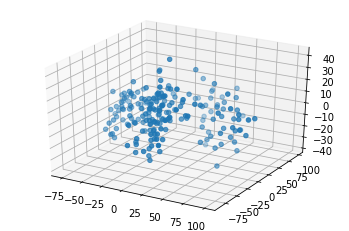

In [404]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

ax.scatter3D(pcadata[:,0], pcadata[:,1], pcadata[:,2])


plt.show()

In [466]:
e_point = np.zeros((11, 2))
for i in range(11):
    c, te, ca = KmeansCentr(pcadata, 10, i+1)
    e_point[i, 1] = te
    e_point[i, 0] = i + 1
e_point

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([[     1.        , 755531.82019883],
       [     2.        , 393736.890157  ],
       [     3.        , 244005.94440111],
       [     4.        , 179172.29038839],
       [     5.        , 132071.61651096],
       [     6.        , 114160.64972797],
       [     7.        , 102004.97840034],
       [     8.        ,  92943.68680739],
       [     9.        ,  85352.06593005],
       [    10.        ,  79309.19989527],
       [    11.        ,  75848.53263959]])

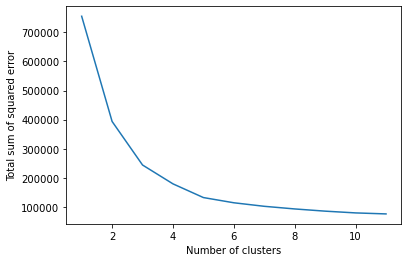

In [467]:
plt.plot(e_point[:,0], e_point[:,1])
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squared error')
plt.show()


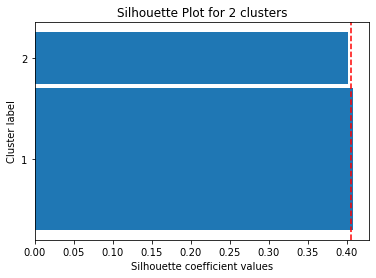

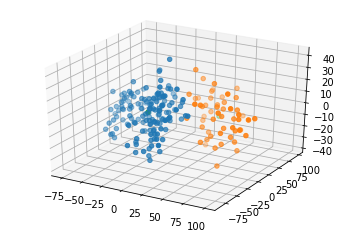

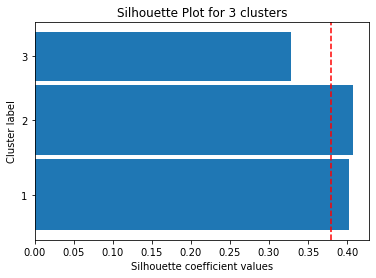

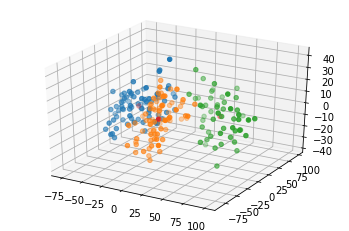

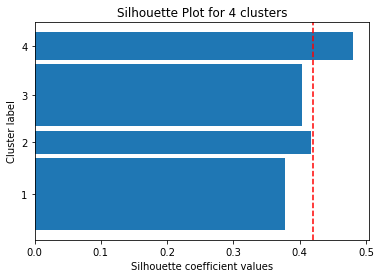

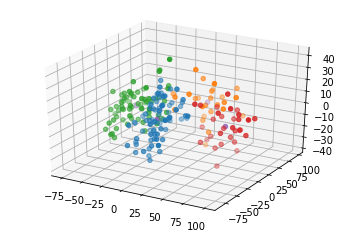

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


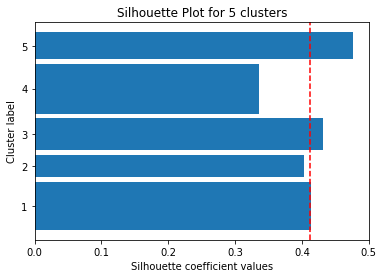

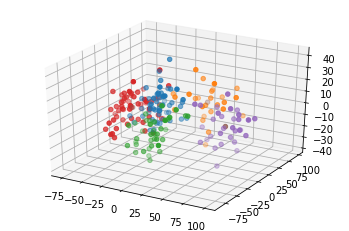

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


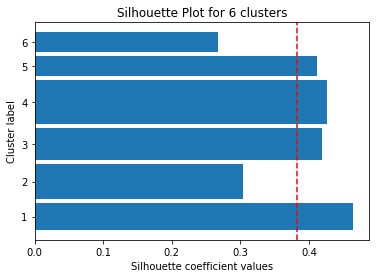

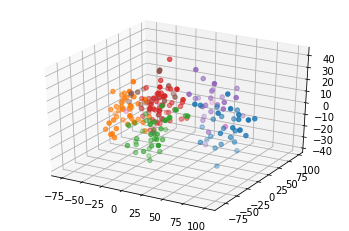

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


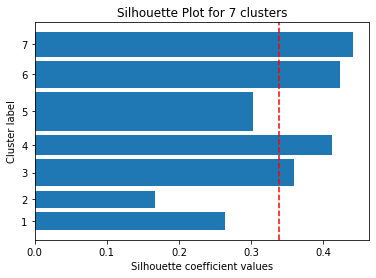

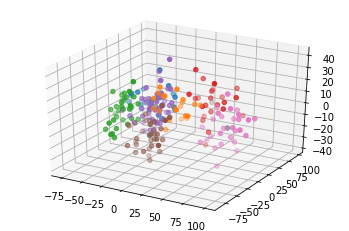

In [468]:
for i in range(6):
    c, te, ca = KmeansCentr(pcadata, 15, i+2)
    sil(pcadata, ca, i+2)

In [435]:
pcadata1 = pcaScale(foot, .85)
pcadata1[:10]

array([[ 19.26693915,  90.62895838],
       [ 34.358507  ,  96.61494005],
       [ 44.71305203,  92.7683754 ],
       [-58.98177562,  51.35991727],
       [ -5.7143076 ,  81.04358632],
       [  4.88640445,  75.46134872],
       [  8.61954167,  87.87307656],
       [-24.22184516,  57.11994233],
       [ 12.44275761,  78.51128712],
       [ 17.13554761,  57.00778532]])

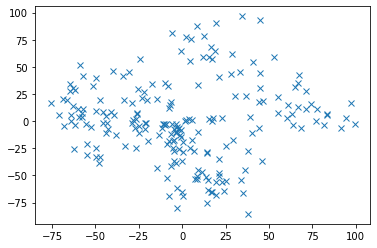

In [438]:
plt.plot(pcadata1[:,0], pcadata1[:,1], 'x')
plt.show()

In [230]:
e_point = np.zeros((11, 2))
for i in range(11):
    c, te, ca = KmeansCentr(pcadata1, 10, i+1)
    e_point[i, 1] = te
    e_point[i, 0] = i + 1
e_point

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([[      1.        , 1028856.22738572],
       [      2.        ,  361454.02561566],
       [      3.        ,  212525.89194638],
       [      4.        ,  151196.00187467],
       [      5.        ,  103679.013198  ],
       [      6.        ,   85956.0471618 ],
       [      7.        ,   77446.54788545],
       [      8.        ,   65949.73113084],
       [      9.        ,   61439.9437073 ],
       [     10.        ,   55858.02357343],
       [     11.        ,   50930.68965456]])

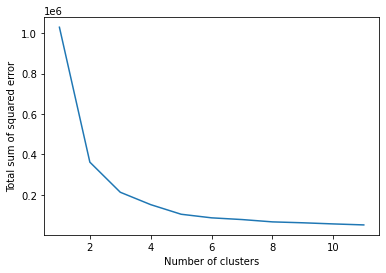

In [440]:
plt.plot(e_point[:,0], e_point[:,1])
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squared error')
plt.show()

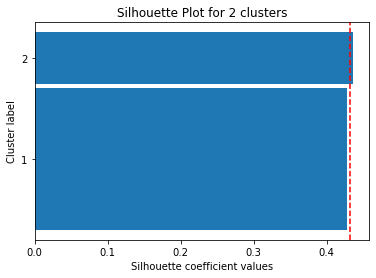

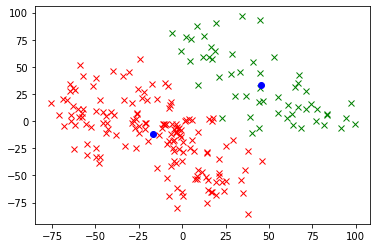

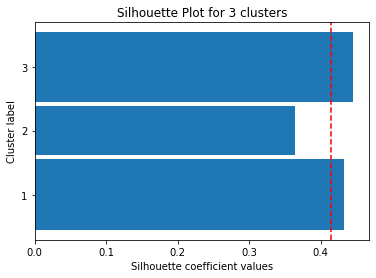

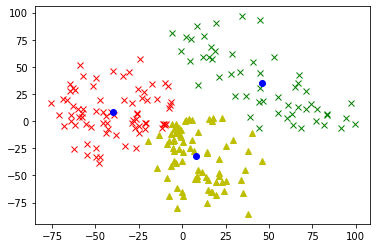

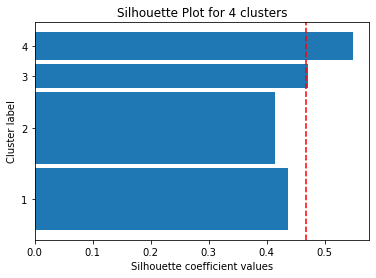

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


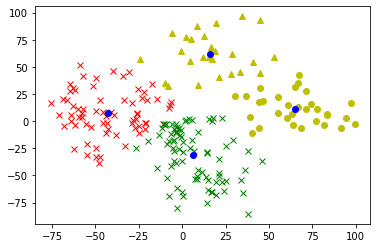

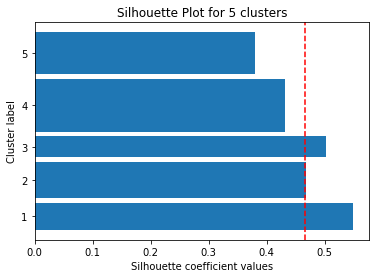

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


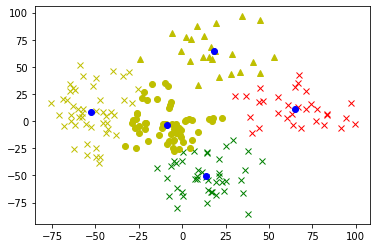

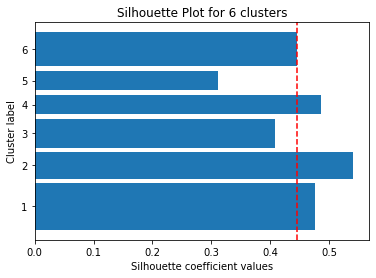

C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\as17s\anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


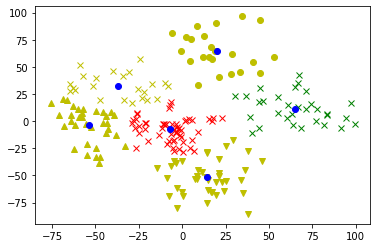

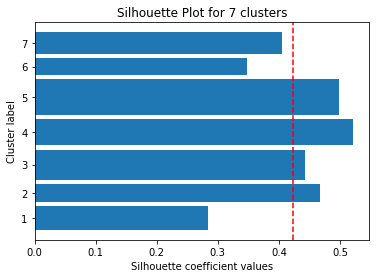

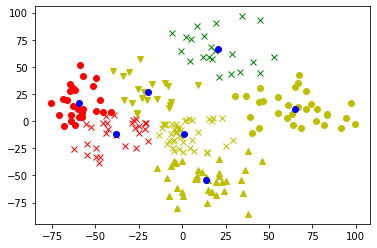

In [416]:
for i in range(6):
    c, te, ca = KmeansCentr(pcadata1, 15, i+2)
    sil(pcadata1, ca, i+2)

In [29]:
te, c, CA = error(pcadata, 10, 3)

te

array([[247945.89926355,      0.        ],
       [247919.51845417,      1.        ],
       [247918.51845417,      2.        ],
       [251317.31360048,      3.        ],
       [247981.89926355,      4.        ],
       [247918.51845417,      5.        ],
       [247873.51845417,      6.        ],
       [247873.51845417,      7.        ],
       [247927.89926355,      8.        ],
       [247918.51845417,      9.        ]])

In [30]:
cf, g, v = finalCent(te, c, CA)
cf

array([[-39.5413973 ,   9.06582143,  -0.2725427 ],
       [  6.74541574, -33.2443172 ,   3.11768645],
       [ 46.88955547,  33.86110847,  -3.9992293 ]])